# House Sqft Living

### Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from mxnet import nd, autograd

In [ ]:
raw_data = pd.read_csv(r'C:\Users\kaihua\Desktop\kc_house_data.csv')
raw_data.drop(['id', 'date'], axis = 1, inplace = True)

In [ ]:
def split_dataset(raw_data, test_rate):
    indices = np.random.permutation(raw_data.shape[0])
    test_cnt = int(raw_data.shape[0] * test_rate)
    train_idx,test_idx=indices[test_cnt:], indices[:test_cnt]
    train, test = raw_data.iloc[train_idx,:], raw_data.iloc[test_idx,:]
    return train.reset_index(drop = True), test.reset_index(drop = True)

### Train & Test Data

In [ ]:
train_data, test_data = split_dataset(raw_data, 0.2)

non_standard_train_feature = train_data.drop('sqft_living', axis = 1)
train_label = train_data['sqft_living']

non_standard_test_feature = test_data.drop('sqft_living', axis = 1)
test_label = test_data['sqft_living']

In [ ]:
# 标准化（0，1）
all_features = pd.concat((non_standard_train_feature.iloc[:, :], non_standard_test_feature.iloc[:, :]))
name_features = all_features.columns
all_features[name_features] = all_features[name_features].apply(lambda x: (x - x.mean()) / (x.std()))

# Ex = 0
all_features[name_features] = all_features[name_features].fillna(0)

# one_hot
all_features = pd.get_dummies(all_features, dummy_na=True)

In [ ]:
number_train = non_standard_train_feature.shape[0]
standard_train_feature = nd.array(all_features[:number_train].values)
standard_test_feature = nd.array(all_features[number_train:].values)

standard_train_label = nd.array(train_label.values)
standard_test_label = nd.array(test_label.values)

In [ ]:
import random
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)

### Model Training

In [ ]:
# 线性模型 Linear model
def linear(x, w, b):
    return nd.dot(x, w) + b

# 均方误差 MSE
def mse_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# # linear gradient
# def gradient(f, x, b):
#     h = 1e-4 #0.0001
#     grad = np.zeros_like(x)
#     for idx in range(x.size):
#         tmp_val = x[idx]
#         #f(x+h)
#         x[idx] = tmp_val + h
#         fxh1 = f(x)
#         #f(x-h)
#         x[idx] = tmp_val-h
#         fxh2 = f(x)
#         grad[idx] = ( fxh1 - fxh2 ) / ( 2 * h )
#         x[idx] = tmp_val
#     return grad

# 优化 SGD
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

In [ ]:
# 初始化
w_size = len(all_features.columns)
b_size = 1
w = nd.random.normal(scale=0.01, shape=(w_size, 1))
b = nd.zeros(shape=(b_size,))

w.attach_grad()
b.attach_grad()

# 参数设置
batch_size = 50
lr = 0.1
num_epochs = 5
net = linear
loss = mse_loss

In [ ]:
for epoch in range(num_epochs):
    for x, y in data_iter(batch_size, standard_train_feature, standard_train_label):
        with autograd.record():
            l = loss(net(x, w, b), y)
        l.backward()
#         l = lambda loss(net(x, w, b), y)
#         w_grad, b_grad = gradient(loss(net(x, w, b), y), )
        sgd([w, b], lr, batch_size)
    train_loss = loss(net(standard_train_feature, w, b), standard_train_label)
    print('epoch %d, loss %f' % (epoch + 1, train_loss.mean().asnumpy()))

**Training output:**

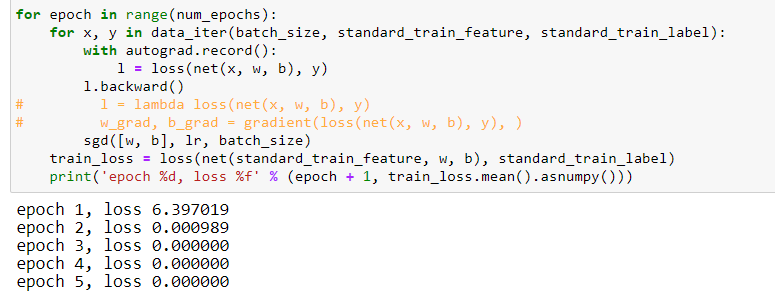

### Model Testing & Evaluation 

In [ ]:
test_loss = loss(net(standard_test_feature, w, b), standard_test_label)
print(net(standard_test_feature, w, b)[:10].reshape(1,10))
print(standard_test_label[:10])
print('loss %f' % (test_loss.mean().asnumpy()))

**output:**

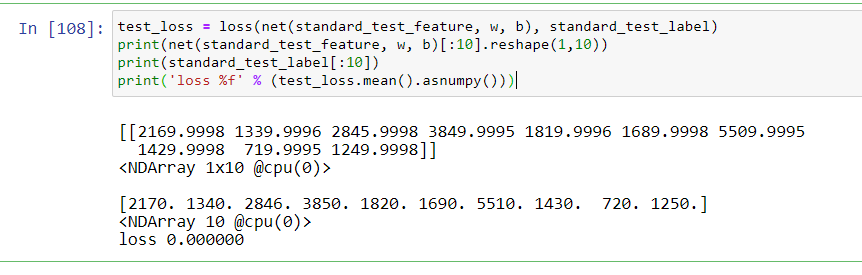